# M1. Actividad

**Nombre:** Diego Antonio García Padilla.

**Matrícula:** A01710777.

## Descripción del Sistema de 'Recolección de Alimentos'

### Objetivo del Sistema

Desarrollar un sistema donde agentes llamados 'exploradores' buscan comida y la llevan de vuelta a su base. Los exploradores se desplazan buscando celdas con alimentos y regresan a la base una vez que encuentran un recurso.

### Características del Sistema:

- **Energía del Explorador:** Cada explorador comienza con una energía máxima de X unidades, y cada movimiento consume 1 unidad de energía. Al llegar a la base, el explorador recarga completamente su energía.
- **Ubicación de la Base:** La base siempre se encuentra en el centro del área de búsqueda.
- **Parámetros del Sistema:**
  - Un área de NxN celdas.
  - Un número específico de exploradores.
  - Una base fija en una celda determinada.
  - Un número de recursos.
  - Un máximo de energía que los exploradores pueden tener.

### Distribución de Agentes y Recursos:

- Tanto los agentes como los recursos se distribuyen aleatoriamente al inicio de la simulación.

### Comportamiento por Paso:

- Si la celda contiene recursos, el agente los recoge y regresa a la base.
- Si la celda no contiene recursos, el agente elige una dirección aleatoria para moverse (una de las 4 celdas vecinas) a una celda sin otro agente. Si no puede moverse allí, permanecerá en la misma celda.

## Instrucciones para la Simulación y el Análisis:

### Simulación Inicial:

- Ejecuta una simulación para una matriz de 11x11 con 5 exploradores y 20 recursos.
- Todos los agentes deben empezar con 100 unidades de energía.
- Muestra gráficamente el comportamiento del modelo.

### Análisis de Eficiencia:

- Analiza cómo la cantidad de exploradores y recursos influye en la eficiencia de la recolección de recursos.
- La eficiencia se medirá observando la cantidad de energía que cada explorador consume durante el proceso de búsqueda y recolección de recursos.
- Para ello, realiza pruebas en un espacio de 15x15 con:
  - 5 y 10 exploradores.
  - 15, 20 y 30 recursos.
- Presenta los hallazgos en el informe, incluyendo gráficos y tablas según sea necesario.

# Instalación e importación de librerías

In [1]:
# Descargar mesa y seaborn
%pip install mesa seaborn --quiet

Note: you may need to restart the kernel to use updated packages.


In [2]:
# Importamos las clases que se requieren para manejar los agentes (Agent) y su entorno (Model).
# Cada modelo puede contener múltiples agentes.
from mesa import Agent, Model

# Debido a que necesitamos que existe un solo agente por celda, elegimos ''SingleGrid''.
from mesa.space import SingleGrid

# Con ''SimultaneousActivation, hacemos que todos los agentes se activen ''al mismo tiempo''.
from mesa.time import SimultaneousActivation

# Haremos uso de ''DataCollector'' para obtener información de cada paso de la simulación.
from mesa.datacollection import DataCollector

# BATCH_RUNNER
from mesa.batchrunner import batch_run

# matplotlib lo usaremos crear una animación de cada uno de los pasos del modelo.
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.animation as animation
plt.rcParams["animation.html"] = "jshtml"
matplotlib.rcParams['animation.embed_limit'] = 2**128

# Importamos los siguientes paquetes para el mejor manejo de valores numéricos.
import numpy as np
import pandas as pd

# Definimos otros paquetes que vamos a usar para medir el tiempo de ejecución de nuestro algoritmo.
import time
import datetime

# Importamos el paquete seaborn para mejorar la visualización de los datos.
import seaborn as sns

# Solución

Para resolver la simulación de manera eficiente, consideré las siguientes reglas para los agentes:

- Para explorar, los exporadores se mueven aleatoriamente para buscar comida.
- Una vez encuentran comida, se dirigen a la base.
- Cuando tienen poca energía, retornan a la base a recargar.

Usando estos principios modelé la clase del agente y del modelo, como está documentado en el código.

A pesar de que puede encontrar toda la comida en prácticamente todas las pruebas, se podría optimizar más usando un algoritmo de backtracking junto con memoria compartida entre los agentes para evitar las casillas que ya visitaron.

## Definición de clases de Agente y Modelo

In [3]:
class ExplorerAgent(Agent):
    """
    Agente que recolecta comida.
    """

    def __init__(self, id, model, max_energy):
        """
        Constructor de la clase Explorer.
        """

        # Inicializamos la clase padre Agent
        super().__init__(id, model)

        # Atributos del agente
        self.model = model

        # Atributo para guardar la energía máxima del agente
        self.max_energy = max_energy

        # Atributo para guardar la energía del agente
        self.energy = max_energy

        # Atributo para saber si el agente tiene comida
        self.hasFood = False

        # Contador de comida recolectada
        self.foodFound = 0

        # Lista para guardar la eficiencia (cuánta energía gastó en recolectar comida)
        self.efficiency = []

        # Umbral de energía para regresar a la base
        self.energy_threshold = 20  

        # Energía usada en encontrar comida
        self.energy_search = 0
        

    def move(self):
        """
        Método que define el comportamiento del agente.
        """

        # Obtener las celdas vecinas
        possible_steps = self.model.grid.get_neighborhood(
            self.pos,
            moore = False,
            include_center = False)

        # Obtener indices del arreglo de posiciones posibles y desordenarlos
        indexes = [x for x in range(len(possible_steps))]
        np.random.shuffle(indexes)

        # Recorrer las celdas vecinas
        for i in indexes:
            (x, y) = possible_steps[i]

            # Si la celda está vacía, moverse a ella
            if self.model.grid.is_cell_empty((x, y)):

                # Mover al agente
                self.model.grid.move_agent(self, (x, y))

                # Actualizar la energía
                self.energy -= 1

                # Actualizar la energía usada en encontrar comida
                self.energy_search += 1

                break

    def move_to_base(self):
        """
        Método que mueve al agente a la base.
        """

        # Obtener las celdas vecinas
        possible_steps = self.model.grid.get_neighborhood(
            self.pos,
            moore = False,
            include_center = False)

        # Obtener posición de la base
        (base_x, base_y) = self.model.base

        # Obtener posición actual del agente
        (x, y) = self.pos

        # Calcular la dirección en la que se moverá el agente
        dx = abs(base_x - x)
        dy = abs(base_y - y)

        # Determinar siguiente posición
        if dx >= dy:
            # Moverse en X
            next_x = x + (1 if base_x > x else -1)
            next_y = y
        else:
            # Moverse en Y
            next_x = x
            next_y = y + (1 if base_y > y else -1)

        # Verificar si la celda a la que se moverá el agente está vacía
        if self.model.grid.is_cell_empty((next_x, next_y)):

            # Mover al agente
            self.model.grid.move_agent(self, (next_x, next_y))

            # Actualizar la energía
            self.energy -= 1

            # Actualizar la energía usada en encontrar comida
            self.energy_search += 1
        
    
    def step(self):
        """
        Paso de simulación para el agente.
        """

        # Comprobar si tiene energía
        if self.energy == 0:
            return

        # Obtener la posición actual del agente
        (x, y) = self.pos

        # ¿El agente está en la base?
        if self.model.cells[x][y] == 2:

            # Si el agente tiene comida, dejarla en la base
            if self.hasFood:
                self.hasFood = False
                self.foodFound += 1
                self.model.food += 1

                # Guardar la eficiencia
                self.efficiency.append(self.max_energy - self.energy_search)

                # Recargar energía
                self.energy = self.max_energy

                # Reiniciar la energía usada en encontrar comida
                self.energy_search = 0

                # Mover al agente
                self.move()

            else:
                # Recargar energía
                self.energy = self.max_energy
                self.move()
        else:
            # Determinar si debe regresar a la base por baja energía
            if self.energy <= self.energy_threshold:
                self.move_to_base()
            # Si el agente tiene comida, moverse a la base
            elif self.hasFood:
                self.move_to_base()
            else:
                # Comprobar si hay comida en la celda actual
                if self.model.cells[x][y] == 1:
                    # Recolectar la comida
                    self.model.cells[x][y] = 0
                    self.hasFood = True
                    self.move_to_base()
                else:
                    self.move()

In [4]:
    """
    Agente que recolecta comida.
    """

    def __init__(self, id, model, max_energy):
        """
        Constructor de la clase Explorer.
        """

        # Inicializamos la clase padre Agent
        super().__init__(id, model)

        # Atributos del agente
        self.model = model

        # Atributo para guardar la energía máxima del agente
        self.max_energy = max_energy

        # Atributo para guardar la energía del agente
        self.energy = max_energy

        # Atributo para saber si el agente tiene comida
        self.hasFood = False

        # Contador de comida recolectada
        self.foodFound = 0

        # Lista para guardar la eficiencia (cuánta energía gastó en recolectar comida)
        self.efficiency = []

        # Umbral de energía para regresar a la base
        self.energy_threshold = 20  

        # Energía usada en encontrar comida
        self.energy_search = 0
        

    def move(self):
        """
        Método que define el comportamiento del agente.
        """

        # Obtener las celdas vecinas
        possible_steps = self.model.grid.get_neighborhood(
            self.pos,
            moore = False,
            include_center = False)

        # Obtener indices del arreglo de posiciones posibles y desordenarlos
        indexes = [x for x in range(len(possible_steps))]
        np.random.shuffle(indexes)

        # Recorrer las celdas vecinas
        for i in indexes:
            (x, y) = possible_steps[i]

            # Si la celda está vacía, moverse a ella
            if self.model.grid.is_cell_empty((x, y)):

                # Mover al agente
                self.model.grid.move_agent(self, (x, y))

                # Actualizar la energía
                self.energy -= 1

                # Actualizar la energía usada en encontrar comida
                self.energy_search += 1

                break

    def move_to_base(self):
        """
        Método que mueve al agente a la base.
        """

        # Obtener las celdas vecinas
        possible_steps = self.model.grid.get_neighborhood(
            self.pos,
            moore = False,
            include_center = False)

        # Obtener posición de la base
        (base_x, base_y) = self.model.base

        # Obtener posición actual del agente
        (x, y) = self.pos

        # Calcular la dirección en la que se moverá el agente
        dx = abs(base_x - x)
        dy = abs(base_y - y)

        # Determinar siguiente posición
        if dx >= dy:
            # Moverse en X
            next_x = x + (1 if base_x > x else -1)
            next_y = y
        else:
            # Moverse en Y
            next_x = x
            next_y = y + (1 if base_y > y else -1)

        # Verificar si la celda a la que se moverá el agente está vacía
        if self.model.grid.is_cell_empty((next_x, next_y)):

            # Mover al agente
            self.model.grid.move_agent(self, (next_x, next_y))

            # Actualizar la energía
            self.energy -= 1

            # Actualizar la energía usada en encontrar comida
            self.energy_search += 1
        
    
    def step(self):
        """
        Paso de simulación para el agente.
        """

        # Comprobar si tiene energía
        if self.energy == 0:
            return

        # Obtener la posición actual del agente
        (x, y) = self.pos

        # ¿El agente está en la base?
        if self.model.cells[x][y] == 2:

            # Si el agente tiene comida, dejarla en la base
            if self.hasFood:
                self.hasFood = False
                self.foodFound += 1
                self.model.food += 1

                # Guardar la eficiencia
                self.efficiency.append(self.max_energy - self.energy_search)

                # Recargar energía
                self.energy = self.max_energy

                # Reiniciar la energía usada en encontrar comida
                self.energy_search = 0

                # Mover al agente
                self.move()

            else:
                # Recargar energía
                self.energy = self.max_energy
                self.move()
        else:
            # Determinar si debe regresar a la base por baja energía
            if self.energy <= self.energy_threshold:
                self.move_to_base()
            # Si el agente tiene comida, moverse a la base
            elif self.hasFood:
                self.move_to_base()
            else:
                # Comprobar si hay comida en la celda actual
                if self.model.cells[x][y] == 1:
                    # Recolectar la comida
                    self.model.cells[x][y] = 0
                    self.hasFood = True
                    self.move_to_base()
                else:
                    self.move()

In [5]:
def get_grid(model):
    grid = np.zeros((model.grid.width, model.grid.height))
    for content, (x, y) in model.grid.coord_iter():
        grid[x][y] = model.cells[x][y]
        if content != None:
            grid[x][y] = 3
    return grid

In [6]:
class WorldModel(Model):
    """
    Modelo del mundo donde los agentes recolectan comida.
    """

    def __init__(self, width = 11, height = 11, num_agents = 5, agents_energy = 100, num_food = 20):
        """
        Constructor de la clase World.
        """

        # Inicializamos la clase padre Model
        super().__init__()

        # Pasos de la simulación
        self.steps = 0

        # Comida recolectada
        self.food = 0

        # Cantidad de comida en el mundo
        self.num_food = 0

        # Grid de la simulación
        self.grid = SingleGrid(width, height, torus = False)

        # Método de activación de los agentes
        self.schedule = SimultaneousActivation(self)

        # Ubicación de la base
        self.base = (width // 2, height // 2)

        # Inicializar celdas
        self.cells = np.zeros((width, height))

        # Agregar comida al mundo
        for _ in range(num_food):

            # Posición aleatoria
            x = np.random.randint(0, width)
            y = np.random.randint(0, height)

            # Comprobar si la celda está vacía
            if self.cells[x][y] == 0:

                # Agregar comida
                self.cells[x][y] = 1

                # Actualizar cantidad de comida
                self.num_food += 1

        # Agregar agentes al mundo
        for i in range(num_agents):
            agent = ExplorerAgent(i, self, agents_energy)
            self.schedule.add(agent)
            self.grid.move_to_empty(agent)
        
        # Definir base
        self.cells[self.base[0]][self.base[1]] = 2

        # Recolectar datos
        self.datacollector = DataCollector(
            model_reporters = {
                "Grid": get_grid,
                "Steps": lambda m: m.steps,
                "Food": lambda m: m.food,
                },
            agent_reporters = {
                "Efficiency": lambda a: sum(a.efficiency) / len(a.efficiency) if len(a.efficiency) > 0 else 0,
                "FoodFound": lambda a: a.foodFound
                }
        )

    def are_food(self):
        """
        Método que verifica si ya se ha recolectado toda la comida.
        """

        # ¿Se ha recolectado toda la comida?
        are_food = self.food < self.num_food

        return are_food
    
    def are_agents_alive(self):
        """
        Método que verifica si hay agentes vivos en el mundo.
        """

        # ¿Hay agentes con energía?
        are_agents_alive = sum(agent.energy > 0 for agent in self.schedule.agents) > 0

        return are_agents_alive
    
    def game_over(self):
        """
        Método que verifica si la simulación ha terminado.
        """

        # ¿No hay agentes vivos o comida en el mundo?
        return not self.are_agents_alive() or not self.are_food()
    
    def step(self):
        """
        Método que define el comportamiento de los agentes en un paso de la simulación.
        """

        # Comprobar que hay agentes vivos y comida en el mundo
        if not self.game_over():
            self.steps += 1
        
        # Recolectar datos
        self.datacollector.collect(self)

        # Activar a los agentes
        self.schedule.step()

## Simulación

In [7]:
X, Y = 11, 11
AGENTS = 5
AGENTS_ENERGY = 100
FOOD = 20

# Inicializar el modelo
model = WorldModel(X, Y, AGENTS, AGENTS_ENERGY, FOOD)

# Ejecutar el modelo
while not model.game_over():
    model.step()

print("Modelo terminado en", model.steps, "pasos")
print("Comida recolectada:", model.food / model.num_food * 100, "%")

Modelo terminado en 368 pasos
Comida recolectada: 100.0 %


In [8]:
all_grids = model.datacollector.get_model_vars_dataframe()
all_grids.head()

,Grid,Steps,Food
0,"[[0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0,...",1,0
1,"[[0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0,...",2,0
2,"[[0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0,...",3,0
3,"[[0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0,...",4,0
4,"[[0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0,...",5,0


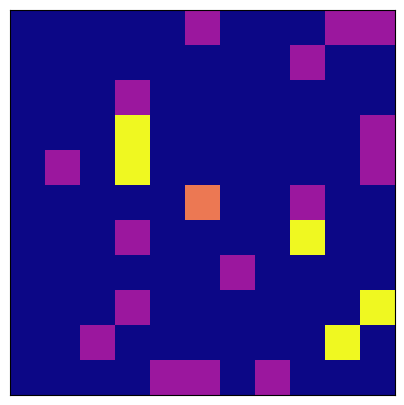

In [9]:
fig, axs = plt.subplots(figsize=(5, 5))
axs.set_xticks([])
axs.set_yticks([])
patch = plt.imshow(all_grids.iloc[0,0], cmap=plt.cm.plasma)

def animate(i):
  patch.set_data(all_grids.iloc[i,0])


anim = animation.FuncAnimation(fig, animate, frames=range(len(all_grids)), repeat=False)

In [10]:
anim

# Análisis

In [11]:
# Parámetros de la simulación
MAX_STEPS = 300
ITERATIONS = 5

## Caso 1

- Espacio 15 x 15
- 5 exploradores
- 15 recursos

In [12]:
params_1 = {
    "width": 15,
    "height": 15,
    "num_agents": 5,
    "num_food": 15
}

results_1 = batch_run(
    WorldModel,
    parameters = params_1,
    iterations = ITERATIONS,
    max_steps = MAX_STEPS,
    number_processes = 1,
    data_collection_period = 1,
    display_progress = True
)

  0%|          | 0/5 [00:00<?, ?it/s]

In [13]:
df_1 = pd.DataFrame(results_1)
data_1 = df_1[(df_1.Step == MAX_STEPS)].drop(
    ['Step', 'width', 'height', 'num_agents', 'num_food', 'Grid'], 
    axis = 1)

In [14]:
data_1.head()

,RunId,iteration,Steps,Food,AgentID,Efficiency,FoodFound
1500,0,0,301,12,0,27.0,2
1501,0,0,301,12,1,-3.5,2
1502,0,0,301,12,2,57.0,3
1503,0,0,301,12,3,56.0,1
1504,0,0,301,12,4,38.0,4


In [15]:
data_1.groupby(['AgentID']).agg(['min', 'mean', 'max'])[['Steps', 'FoodFound', 'Efficiency']]

Steps             FoodFound          Efficiency                      
          min   mean  max       min mean max        min       mean        max
AgentID                                                                      
0         213  283.4  301         1  2.0   3  10.666667  48.333333  74.500000
1         213  283.4  301         2  2.6   5 -30.500000  29.400000  67.000000
2         213  283.4  301         2  2.8   3  36.000000  54.666667  72.333333
3         213  283.4  301         1  2.6   6  52.666667  71.800000  90.000000
4         213  283.4  301         0  2.2   4  -6.000000  36.000000  91.000000

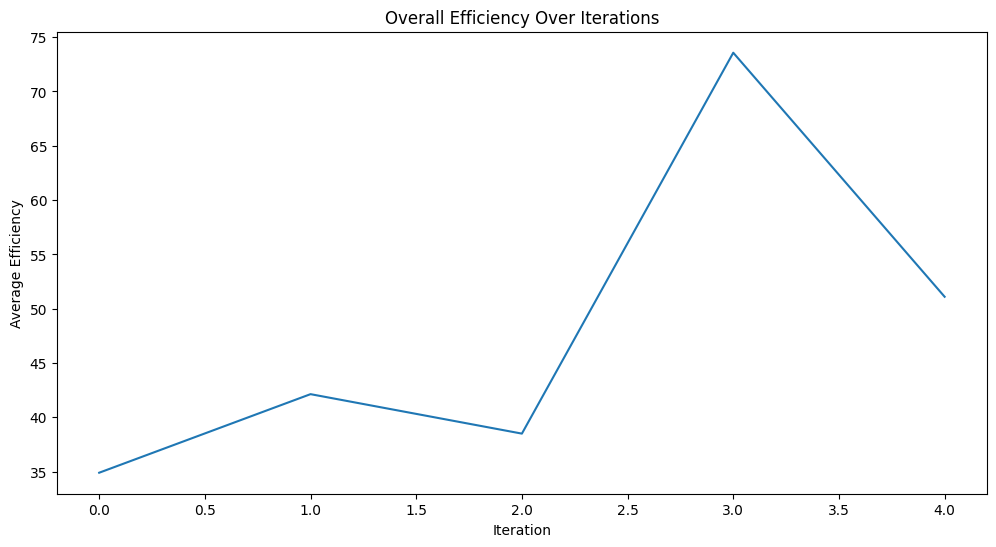

In [16]:
grouped_1 = data_1.groupby('iteration')['Efficiency'].mean().reset_index()

plt.figure(figsize=(12, 6))
sns.lineplot(x="iteration", y="Efficiency", data=grouped_1)
plt.title("Overall Efficiency Over Iterations")
plt.xlabel("Iteration")
plt.ylabel("Average Efficiency")
plt.show()

## Caso 2

- Espacio 15 x 15
- 5 exploradores
- 20 recursos

In [17]:
params_2 = {
    "width": 15,
    "height": 15,
    "num_agents": 5,
    "num_food": 20
}

results_2 = batch_run(
    WorldModel,
    parameters = params_2,
    iterations = ITERATIONS,
    max_steps = MAX_STEPS,
    number_processes = 1,
    data_collection_period = 1,
    display_progress = True
)

  0%|          | 0/5 [00:00<?, ?it/s]

In [18]:
df_2 = pd.DataFrame(results_2)
data_2 = df_2[(df_2.Step == MAX_STEPS)].drop(
    ['Step', 'width', 'height', 'num_agents', 'num_food', 'Grid'], 
    axis = 1)

In [19]:
data_2.head()

,RunId,iteration,Steps,Food,AgentID,Efficiency,FoodFound
1500,0,0,301,14,0,58.666667,3
1501,0,0,301,14,1,35.000000,3
1502,0,0,301,14,2,43.000000,3
1503,0,0,301,14,3,53.000000,3
1504,0,0,301,14,4,22.000000,2


In [20]:
data_2.groupby(['AgentID']).agg(['min', 'mean', 'max'])[['Steps', 'FoodFound', 'Efficiency']]

Steps             FoodFound          Efficiency                      
          min   mean  max       min mean max        min       mean        max
AgentID                                                                      
0         301  301.0  301         2  3.6   6  31.666667  58.566667  93.000000
1         301  301.0  301         2  2.8   4  23.000000  43.083333  64.500000
2         301  301.0  301         2  3.2   5  28.666667  53.846667  71.500000
3         301  301.0  301         3  3.0   3  22.000000  59.466667  80.333333
4         301  301.0  301         2  2.8   4  11.000000  34.150000  77.333333

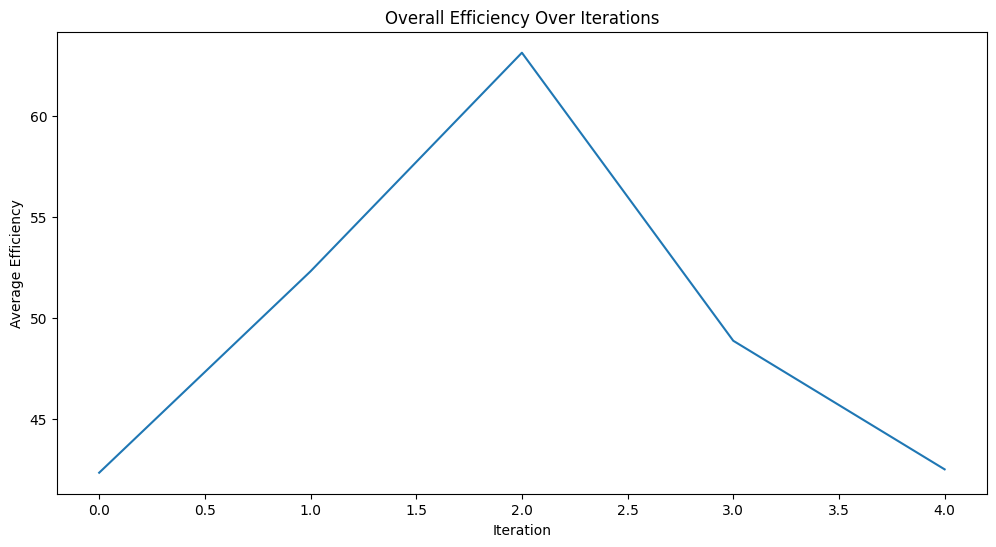

In [21]:
grouped_2 = data_2.groupby('iteration')['Efficiency'].mean().reset_index()

plt.figure(figsize=(12, 6))
sns.lineplot(x="iteration", y="Efficiency", data=grouped_2)
plt.title("Overall Efficiency Over Iterations")
plt.xlabel("Iteration")
plt.ylabel("Average Efficiency")
plt.show()

## Caso 3

- Espacio 15 x 15
- 5 exploradores
- 30 recursos

In [22]:
params_3 = {
    "width": 15,
    "height": 15,
    "num_agents": 5,
    "num_food": 30
}

results_3 = batch_run(
    WorldModel,
    parameters = params_3,
    iterations = ITERATIONS,
    max_steps = MAX_STEPS,
    number_processes = 1,
    data_collection_period = 1,
    display_progress = True
)

  0%|          | 0/5 [00:00<?, ?it/s]

In [23]:
df_3 = pd.DataFrame(results_3)
data_3 = df_3[(df_1.Step == MAX_STEPS)].drop(
    ['Step', 'width', 'height', 'num_agents', 'num_food', 'Grid'], 
    axis = 1)

In [24]:
data_3.head()

,RunId,iteration,Steps,Food,AgentID,Efficiency,FoodFound
1500,0,0,301,19,0,65.75,4
1501,0,0,301,19,1,45.25,4
1502,0,0,301,19,2,60.00,5
1503,0,0,301,19,3,71.50,2
1504,0,0,301,19,4,57.00,4


In [25]:
data_3.groupby(['AgentID']).agg(['min', 'mean', 'max'])[['Steps', 'FoodFound', 'Efficiency']]

Steps             FoodFound          Efficiency                      
          min   mean  max       min mean max        min       mean        max
AgentID                                                                      
0         301  301.0  301         2  4.2   8      -39.0  30.370000  74.000000
1         301  301.0  301         2  3.6   5      -24.5  42.426667  68.333333
2         301  301.0  301         2  3.6   5       26.0  42.380000  60.000000
3         301  301.0  301         1  3.2   5      -96.0  20.900000  71.500000
4         301  301.0  301         4  5.0   7       44.0  57.451429  64.800000

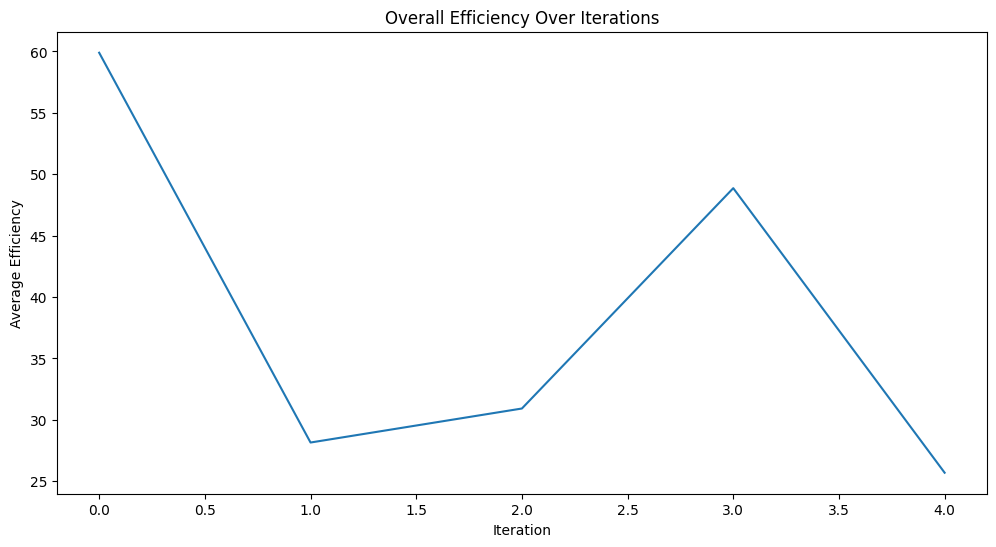

In [26]:
grouped_3 = data_3.groupby('iteration')['Efficiency'].mean().reset_index()

plt.figure(figsize=(12, 6))
sns.lineplot(x="iteration", y="Efficiency", data=grouped_3)
plt.title("Overall Efficiency Over Iterations")
plt.xlabel("Iteration")
plt.ylabel("Average Efficiency")
plt.show()

## Caso 4

- Espacio 15 x 15
- 10 exploradores
- 15 recursos

In [27]:
params_4 = {
    "width": 15,
    "height": 15,
    "num_agents": 10,
    "num_food": 15
}

results_4 = batch_run(
    WorldModel,
    parameters = params_4,
    iterations = ITERATIONS,
    max_steps = MAX_STEPS,
    number_processes = 1,
    data_collection_period = 1,
    display_progress = True
)

  0%|          | 0/5 [00:00<?, ?it/s]

In [28]:
df_4 = pd.DataFrame(results_4)
data_4 = df_4[(df_4.Step == MAX_STEPS)].drop(
    ['Step', 'width', 'height', 'num_agents', 'num_food', 'Grid'], 
    axis = 1)

In [29]:
data_4.head()

,RunId,iteration,Steps,Food,AgentID,Efficiency,FoodFound
3000,0,0,218,15,0,86.0,1
3001,0,0,218,15,1,58.0,1
3002,0,0,218,15,2,41.0,1
3003,0,0,218,15,3,47.0,4
3004,0,0,218,15,4,-21.0,1


In [30]:
data_4.groupby(['AgentID']).agg(['min', 'mean', 'max'])[['Steps', 'FoodFound', 'Efficiency']]

Steps             FoodFound          Efficiency                 
          min   mean  max       min mean max        min       mean   max
AgentID                                                                 
0         204  251.2  301         1  1.8   3 -25.000000  37.166667  86.0
1         204  251.2  301         1  1.4   2 -50.000000  33.500000  71.0
2         204  251.2  301         0  1.0   2 -50.000000  17.400000  73.0
3         204  251.2  301         1  1.6   4  47.000000  71.800000  88.0
4         204  251.2  301         0  1.0   2 -21.000000  22.300000  80.0
5         204  251.2  301         0  0.8   2 -24.000000  11.500000  80.5
6         204  251.2  301         1  1.8   3   4.333333  65.933333  92.0
7         204  251.2  301         1  2.0   5   0.000000  51.260000  94.0
8         204  251.2  301         0  1.2   4   0.000000  50.800000  93.0
9         204  251.2  301         0  1.4   3 -97.000000   2.366667  77.0

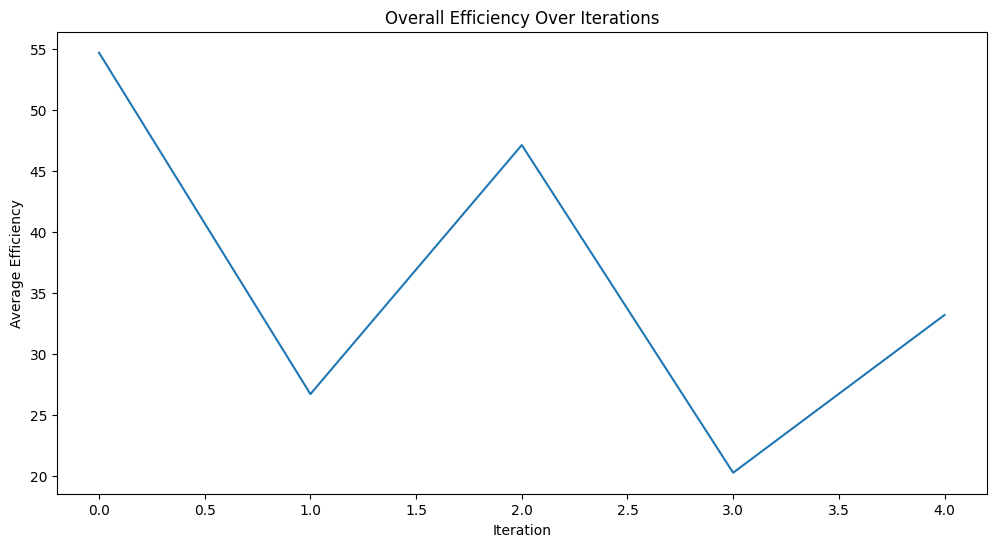

In [31]:
grouped_4 = data_4.groupby('iteration')['Efficiency'].mean().reset_index()

plt.figure(figsize=(12, 6))
sns.lineplot(x="iteration", y="Efficiency", data=grouped_4)
plt.title("Overall Efficiency Over Iterations")
plt.xlabel("Iteration")
plt.ylabel("Average Efficiency")
plt.show()

## Caso 5

- Espacio 15 x 15
- 10 exploradores
- 20 recursos

In [32]:
params_5 = {
    "width": 15,
    "height": 15,
    "num_agents": 10,
    "num_food": 20
}

results_5 = batch_run(
    WorldModel,
    parameters = params_5,
    iterations = ITERATIONS,
    max_steps = MAX_STEPS,
    number_processes = 1,
    data_collection_period = 1,
    display_progress = True
)

  0%|          | 0/5 [00:00<?, ?it/s]

In [33]:
df_5 = pd.DataFrame(results_5)
data_5 = df_5[(df_4.Step == MAX_STEPS)].drop(
    ['Step', 'width', 'height', 'num_agents', 'num_food', 'Grid'], 
    axis = 1)

In [34]:
data_5.head()

,RunId,iteration,Steps,Food,AgentID,Efficiency,FoodFound
3000,0,0,240,18,0,0.000000,0
3001,0,0,240,18,1,51.000000,2
3002,0,0,240,18,2,67.333333,3
3003,0,0,240,18,3,-13.500000,2
3004,0,0,240,18,4,50.500000,2


In [35]:
data_5.groupby(['AgentID']).agg(['min', 'mean', 'max'])[['Steps', 'FoodFound', 'Efficiency']]

Steps             FoodFound          Efficiency                      
          min   mean  max       min mean max        min       mean        max
AgentID                                                                      
0         114  230.0  301         0  2.0   4        0.0  48.483333  85.666667
1         114  230.0  301         0  1.4   3      -67.0  28.400000  83.000000
2         114  230.0  301         1  2.4   3      -31.0  42.933333  82.333333
3         114  230.0  301         1  2.2   3      -13.5  20.833333  76.666667
4         114  230.0  301         1  1.6   2       50.5  67.200000  92.000000
5         114  230.0  301         0  2.0   4        0.0  49.433333  85.500000
6         114  230.0  301         0  1.8   3        0.0  44.100000  88.000000
7         114  230.0  301         1  1.6   2       19.0  59.800000  85.500000
8         114  230.0  301         0  1.2   4        0.0  25.700000  74.000000
9         114  230.0  301         1  1.6   2      -97.0  12.400000  69.500000

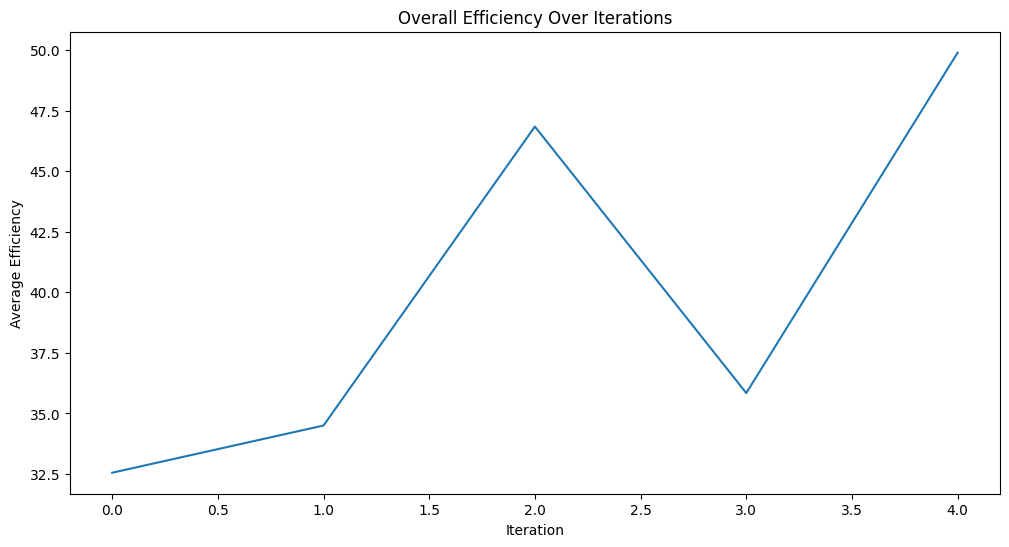

In [36]:
grouped_5 = data_5.groupby('iteration')['Efficiency'].mean().reset_index()

plt.figure(figsize=(12, 6))
sns.lineplot(x="iteration", y="Efficiency", data=grouped_5)
plt.title("Overall Efficiency Over Iterations")
plt.xlabel("Iteration")
plt.ylabel("Average Efficiency")
plt.show()

## Caso 6

- Espacio 15 x 15
- 10 exploradores
- 30 recursos

In [37]:
params_6 = {
    "width": 15,
    "height": 15,
    "num_agents": 10,
    "num_food": 30
}

results_6 = batch_run(
    WorldModel,
    parameters = params_6,
    iterations = ITERATIONS,
    max_steps = MAX_STEPS,
    number_processes = 1,
    data_collection_period = 1,
    display_progress = True
)

  0%|          | 0/5 [00:00<?, ?it/s]

In [38]:
df_6 = pd.DataFrame(results_6)
data_6 = df_6[(df_6.Step == MAX_STEPS)].drop(
    ['Step', 'width', 'height', 'num_agents', 'num_food', 'Grid'], 
    axis = 1)

In [39]:
data_6.head()

,RunId,iteration,Steps,Food,AgentID,Efficiency,FoodFound
3000,0,0,301,27,0,70.000000,2
3001,0,0,301,27,1,78.600000,5
3002,0,0,301,27,2,49.000000,1
3003,0,0,301,27,3,54.333333,3
3004,0,0,301,27,4,-107.000000,1


In [40]:
data_6.groupby(['AgentID']).agg(['min', 'mean', 'max'])[['Steps', 'FoodFound', 'Efficiency']]

Steps             FoodFound          Efficiency                      
          min   mean  max       min mean max        min       mean        max
AgentID                                                                      
0         301  301.0  301         2  2.8   4       30.5  56.700000  83.666667
1         301  301.0  301         0  2.4   5      -37.5  38.320000  89.000000
2         301  301.0  301         1  2.2   3       12.0  51.833333  70.000000
3         301  301.0  301         1  2.2   3      -41.5  37.333333  83.333333
4         301  301.0  301         1  1.8   3     -107.0  22.200000  89.000000
5         301  301.0  301         1  3.2   5      -31.0  30.370000  62.750000
6         301  301.0  301         1  2.8   5        3.5  48.646667  89.000000
7         301  301.0  301         1  2.8   4        9.0  49.266667  93.000000
8         301  301.0  301         1  2.6   4      -17.0  37.733333  71.666667
9         301  301.0  301         2  3.0   4       36.0  59.833333  82.000000

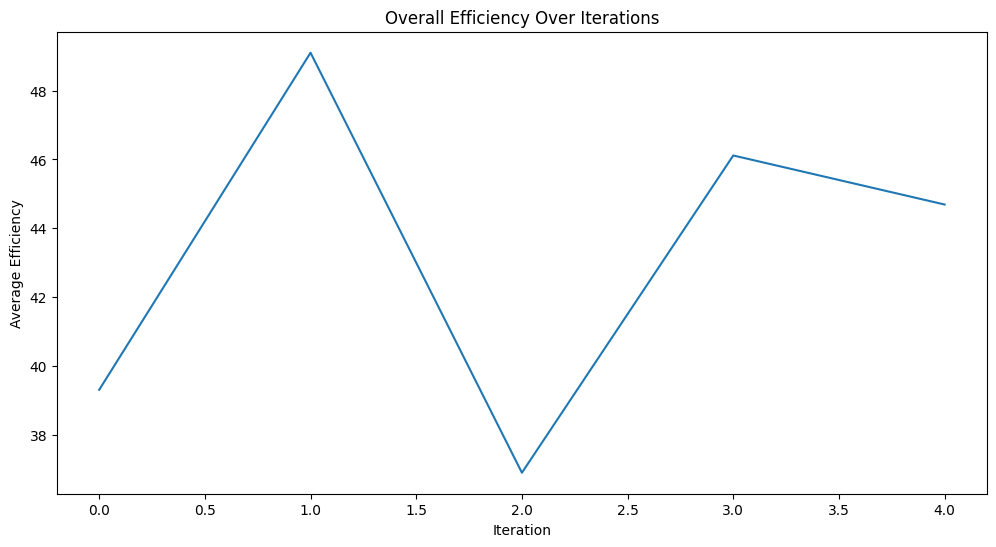

In [41]:
grouped_6 = data_6.groupby('iteration')['Efficiency'].mean().reset_index()

plt.figure(figsize=(12, 6))
sns.lineplot(x="iteration", y="Efficiency", data=grouped_6)
plt.title("Overall Efficiency Over Iterations")
plt.xlabel("Iteration")
plt.ylabel("Average Efficiency")
plt.show()